<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EC%83%81%EC%A0%90%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EB%A7%A4%EC%B6%9C%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EC%83%81%EC%A0%90_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EB%A7%A4%EC%B6%9C_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theme

[데이콘 : 상점 신용카드 매출 예측 경진대회](https://dacon.io/competitions/official/140472/overview/description)


[Reference 1](https://dacon.io/competitions/official/140472/codeshare/419?page=2&dtype=recent)

핀테크 기업인 ‘FUNDA(펀다)’는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.

---

이번 대회에서는 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다.

# Setting

## 라이브러리 불러오기

In [1]:
# 기본
import itertools # 자신만의 반복자를 만드는 모듈
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib # 디스크 캐싱, 병렬 프로그래밍, 학습한 모델을 저장
from sklearn.metrics import make_scorer

In [2]:
# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta # 날짜 계산
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [4]:
# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [5]:
# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format
from tqdm.notebook import tqdm

## 예측 오차

MAE (Mean Absolute Error) : 절대평균오차

In [6]:
def mae(prediction, correct):

  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()

  return score

mae_score = make_scorer(mae)
mae_score

make_scorer(mae)

## 데이터 불러오기

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/funda_train.csv' 
sub_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/submission.csv'

df_train = pd.read_csv(train_path)
df_sub = pd.read_csv(sub_path)

## 데이터 확인하기

In [9]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [10]:
df_train.shape

(6556613, 9)

In [11]:
df_train.info()
# store_id : 상점의 고유 아이디
# card_id : 사용한 카드의 고유 아이디
# card_company : 비식별화된 카드 회사
# trasacted_date : 거래 날짜
# transacted_time : 거래 시간( 시:분 )
# installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
# region : 상점의 지역
# type_of_business : 상점의 업종
# amount : 거래액(단위는 원이 아닙니다)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [12]:
# 각 Column 별 고유값 개수, Null 개수, type, 앞에서 부터의 5개 샘플을 확인

frame_info = [(col, # 각각의 Column
               len(df_train[col].unique()), # 고유값 개수
               df_train[col].isnull().sum(), # Null 개수
               df_train[col].dtype, # type
               df_train[col].unique()[:5]) # 앞에서 부터의 5개 샘플을 확인
               for col in df_train.columns]

df_info = pd.DataFrame(frame_info,
                       columns=['name', 'num_of_unique',
                                'num_of_nan', 'type',
                                'front5_values'])

In [13]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,object,"[2016-06-01, 2016-06-02, 2016-06-03, 2016-06-0..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


# 데이터 전처리

## 시계열 분석을 위해 date를 index로 변환

In [14]:
df_train = df_train.set_index('transacted_date')

In [15]:
df_train.head()

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.14286
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.00000


## 새로운 Columns 생성


* 'store_id', 'region', 'type_of_business' 기존과 동일
* day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
* business_day : working day 여부, 1이면 working day 0이면 주말
* num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
* num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
* installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
* amount : 일 매출 액, 기존 amount의 합

In [16]:
def preprocessing_day(DataFrame):
  
  # 새로운 데이터 프레임 생성
  new_df = pd.DataFrame()


  for store in tqdm(DataFrame.store_id.unique()):

    # 데이터 셋에서 상점의 고유 아이디 별 데이터 추출
    unique_store = DataFrame[DataFrame.store_id == store]
    unique_store.index = pd.to_datetime(unique_store.index)

    # '일 (day)'별로 사용한 카드의 고유 아이디별로 거래 횟수 확인
    count_cols = unique_store['card_id'].resample(rule='d').count().rename('num_of_pay')


    # 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
    count_visit = unique_store.card_id.value_counts().reset_index()

    cond_visit = (count_visit['card_id'] > 2)
    
    revisit_idx = count_visit.loc[cond_visit]["index"].values

    df_revisit = unique_store[unique_store.card_id.isin(revisit_idx)]
    df_revisit.index = pd.to_datetime(df_revisit.index)

    revisit_ct = df_revisit[df_revisit.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')

    # 할부 개월수와 매출액은 일 단위로 합
    sum_cols = unique_store[['installment_term', 'amount']].resample(rule='d').sum()

    # 새로운 Columns 병합
    preprocessing_df = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

    # 기존 Columns 불러오기
    preprocessing_df.insert(0, 'store_id', store)
    preprocessing_df.insert(4, 'region', unique_store[unique_store.store_id == store].region.unique()[0])
    preprocessing_df.insert(5, 'type_of_business', unique_store[unique_store.store_id == store].type_of_business.unique()[0])

    # 모두 병합
    new_df = pd.concat([new_df, preprocessing_df], axis=0)

  # 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
  new_df.insert(1, 'day_of_week', new_df.index.dayofweek)

  # working day 여부, 1이면 working day 0이면 주말
  new_df.insert(2, 'business_day', new_df.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)

  # 단골 방문이 없는 경우 0으로 대체
  new_df.num_of_revisit.fillna(0, inplace=True)

  return new_df

In [17]:
day_df = preprocessing_day(df_train)

  0%|          | 0/1967 [00:00<?, ?it/s]

## 전처리된 데이터 확인하기

In [18]:
day_df.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143


In [19]:
day_df.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [20]:
df_corr = day_df.corr()
df_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


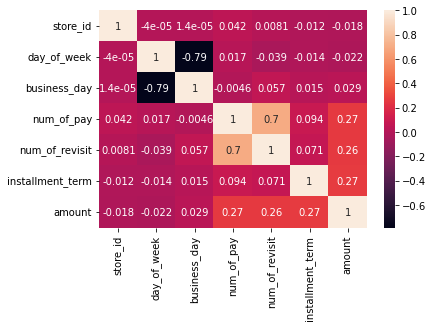

In [21]:
sns.heatmap(df_corr, annot=True)

## Modeling을 위해 Month 단위로 변환

* 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음 
* month 주기로 resampling 후 forecast 범위를 3개월로 지정하여 해결

In [22]:
def preprocessing_month(day_df):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for store in tqdm(day_df.store_id.unique()):
        df_set = day_df[day_df.store_id == store]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)),
                                  end=(df_set.index[0] - relativedelta(months=1)))
        
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)),
                                 end=(df_set.index[-1] + relativedelta(months=1)))
        
        df_set = pd.concat([pd.DataFrame(index=prev_date),
                            df_set,
                            pd.DataFrame(index=add_date)],
                            axis=0)

        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', store)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [23]:
month_df = preprocessing_month(day_df)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [24]:
month_df.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [38]:
print("rate of 'region' :" , month_df.region.isnull().sum() / len(month_df))
print("rate of 'type_of_business' :" , month_df.type_of_business.isnull().sum() / len(month_df))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [39]:
month_df = month_df.drop(['region', 'type_of_business'], axis=1)
month_df.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [41]:
month_df.shape

(60915, 7)

In [42]:
month_df.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06964,15.89620,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75343,5.63154,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


# EDA

## target 변수의 대칭성(정규성) 확인

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

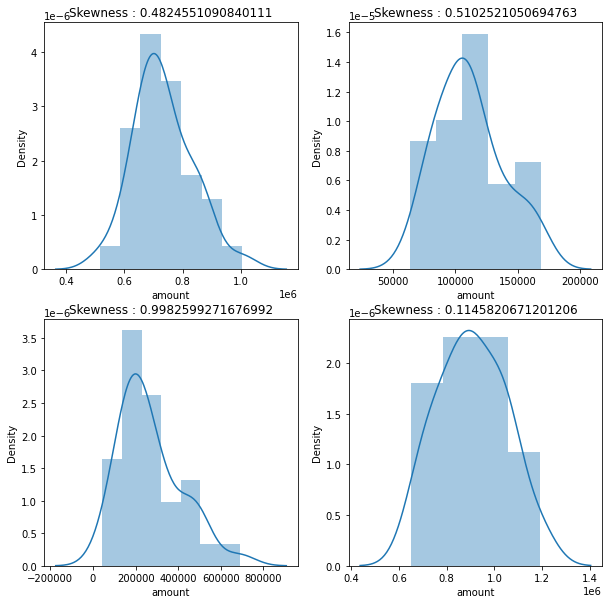

In [67]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))

for i, z in zip(month_df.store_id.unique()[:4], [[0,0], [0,1], [1,0], [1,1]]):
    sns.distplot(month_df[month_df.store_id == i].amount,
                 ax=ax[z[0], z[-1]]).set(title='Skewness : '+str(month_df[month_df.store_id == i].amount.skew()))

## 각 변수의 value 분포 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

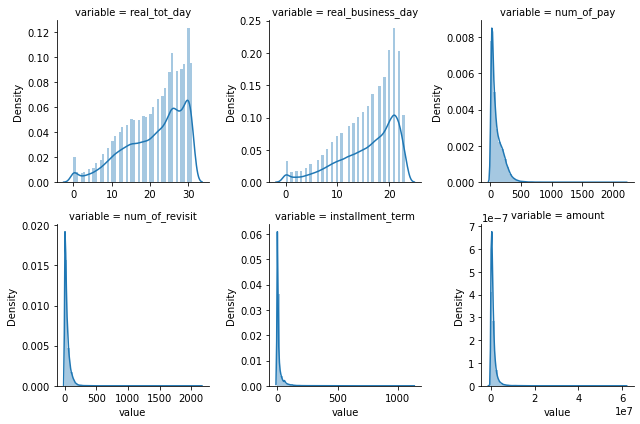

In [71]:
f = pd.melt(month_df, value_vars=month_df.columns[1:])
g = sns.FacetGrid(f, col="variable",  col_wrap=3,
                  sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

## 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인(Store_id : 0~10)


각 store_id별로 다른 trend와 seasonality, scale을 가지는 것을 확인

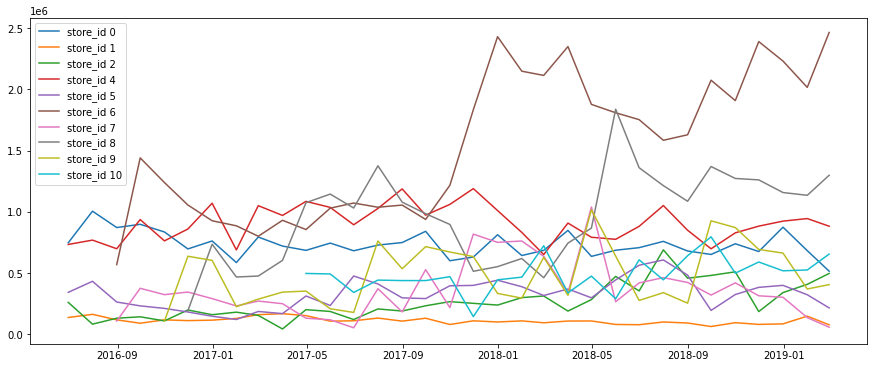

In [72]:
plt.figure(figsize=(15, 6))
for i in month_df.store_id.unique()[:10]:
    plt.plot(month_df[month_df.store_id == i].index, month_df[month_df.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()